In [1]:
import praw
import pandas as pd
from datetime import datetime, timedelta
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.dates as pdt
import mysql.connector
import re
from tqdm import tqdm

In [2]:
db_connection = mysql.connector.connect(
  host= "wp.jagi.wtf",
  user= "redditu",
  password= "redditMaster",
  database="reddit"
  )

In [3]:
cursor = db_connection.cursor()

In [4]:
dfru = pd.read_sql("SELECT * FROM users", db_connection)

# Erfahrung der Reddituser, die in die Top Posts gekommen sind

In [5]:
dfru["created"] = pd.to_datetime(dfru["created_utc"], unit='s') 
dfru["time_since_creation"] = (datetime.now() - dfru["created"]) 
dfru["years_since_creation"] = dfru["time_since_creation"].dt.days/365

/home/jakob/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


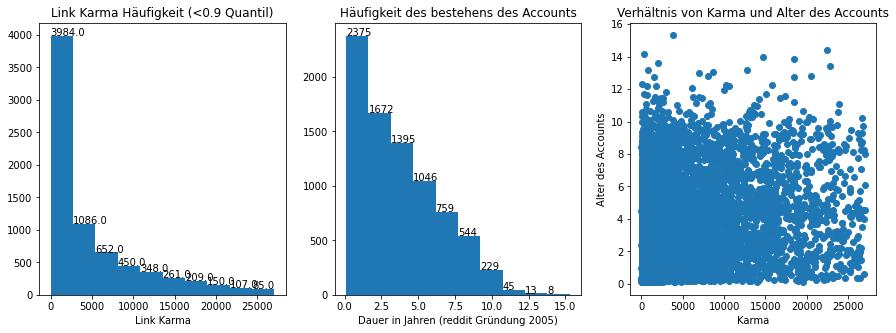

In [6]:
my_bins = 10

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))

arr = ax1.hist(dfru[dfru["link_karma"]<dfru["link_karma"].quantile(0.9)]["link_karma"], bins=my_bins)
ax1.set_title("Link Karma Häufigkeit (<0.9 Quantil)")
ax1.set_xlabel("Link Karma")
for i in range(my_bins):
    ax1.text(arr[1][i],arr[0][i],str(arr[0][i]))


arr = ax2.hist(dfru[dfru["years_since_creation"]<20]["years_since_creation"], bins=my_bins)
ax2.set_title("Häufigkeit des bestehens des Accounts")
ax2.set_xlabel("Dauer in Jahren (reddit Gründung 2005)")
for i in range(my_bins):
    ax2.text(arr[1][i],arr[0][i],str(int(arr[0][i])))

ax3.scatter(dfru[(dfru["link_karma"]<dfru["link_karma"].quantile(0.9))& (dfru["years_since_creation"]<20)]["link_karma"], dfru[(dfru["link_karma"]<dfru["link_karma"].quantile(0.9))& (dfru["years_since_creation"]<20)]["years_since_creation"])
ax3.set_xlabel("Karma")
ax3.set_ylabel("Alter des Accounts")
ax3.set_title("Verhältnis von Karma und Alter des Accounts")

fig.show()

# Mods 

/home/jakob/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


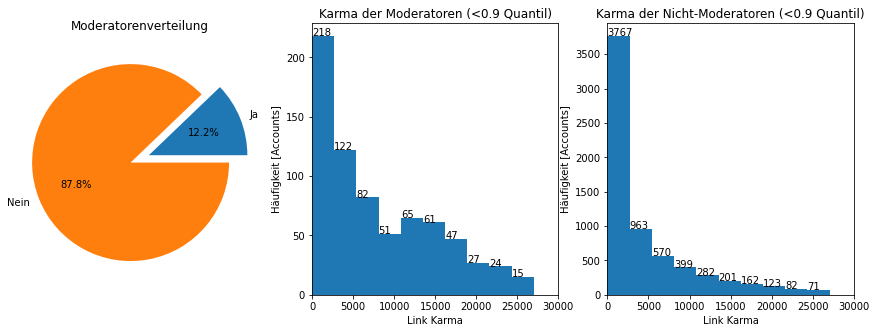

In [7]:
my_bins= 10 #Konfig

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))

ax1.set_title("Moderatorenverteilung")    
ax1.pie([(dfru["is_mod"].sum()/dfru["is_mod"].count()), ((dfru["is_mod"].count()-dfru["is_mod"].sum())/dfru["is_mod"].count())], 
        labels=["Ja", "Nein"],
       autopct='%1.1f%%', explode=(0.1,0.1))


arr = ax2.hist(dfru[(dfru["is_mod"]==1)& (dfru["link_karma"]< dfru["link_karma"].quantile(0.9))]["link_karma"], bins=my_bins)
ax2.set_xlabel("Link Karma")
ax2.set_title("Karma der Moderatoren (<0.9 Quantil)")
ax2.set_ylabel("Häufigkeit [Accounts]")
ax2.set_xlim([0,30000])

for i in range(my_bins):
    ax2.text(arr[1][i],arr[0][i],str(int(arr[0][i])))

    

arr = ax3.hist(dfru[(dfru["is_mod"]==0)& (dfru["link_karma"]< dfru["link_karma"].quantile(0.9))]["link_karma"], bins=my_bins)
ax3.set_xlabel("Link Karma")
ax3.set_title("Karma der Nicht-Moderatoren (<0.9 Quantil)")
ax3.set_ylabel("Häufigkeit [Accounts]")
ax3.set_xlim([0,30000])
for i in range(my_bins):
    ax3.text(arr[1][i],arr[0][i],str(int(arr[0][i])))


fig.show()

/home/jakob/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


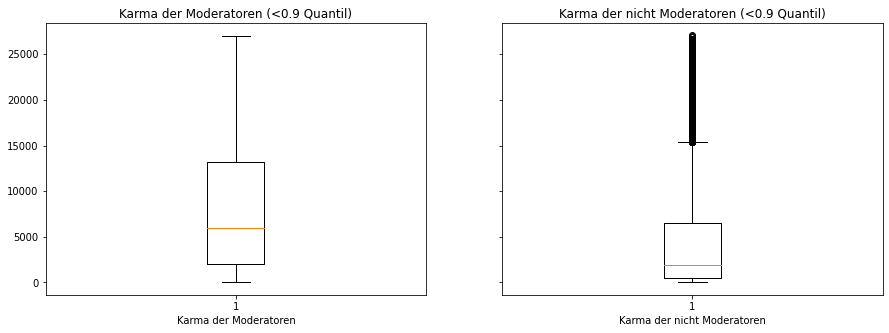

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharey=True)


ax1.boxplot(dfru[(dfru["is_mod"]==1) & (dfru["link_karma"]< dfru["link_karma"].quantile(0.9))]["link_karma"])
ax1.set_title("Karma der Moderatoren (<0.9 Quantil)")
ax1.set_xlabel("Karma der Moderatoren")

ax2.boxplot(dfru[(dfru["is_mod"]==0) & (dfru["link_karma"]< dfru["link_karma"].quantile(0.9))]["link_karma"])
ax2.set_title("Karma der nicht Moderatoren (<0.9 Quantil)")
ax2.set_xlabel("Karma der nicht Moderatoren")

fig.show()

# Mods & Erfolg im Datensatz

In [26]:
dfr = pd.read_sql("SELECT * FROM reddit", db_connection)

In [27]:
dfru = pd.read_sql("SELECT * FROM users", db_connection)

# Erfolgreichste Autoren
(näheres bei Alex)

In [11]:
dfru[dfru["username"]=="SoonerMagic10"]

,uid,username,created_utc,is_mod,is_employee,link_karma,created,time_since_creation,years_since_creation
6644,14792,SoonerMagic10,1380774705.0,0,0,159157,2013-10-03 04:31:45,2748 days 12:40:14.683423,7.528767


In [12]:
dfru[dfru["username"]=="sugurkewbz"]

,uid,username,created_utc,is_mod,is_employee,link_karma,created,time_since_creation,years_since_creation
6858,15006,sugurkewbz,1435617940.0,0,0,62391,2015-06-29 22:45:40,2113 days 18:26:19.683423,5.789041


In [16]:
dfru["link_karma"].quantile(0.95)

51335.79999999994

In [17]:
dfru["years_since_creation"].quantile(0.9)

7.917808219178081